# Prepairing data


This code will output 2 csv files in total
> df_master.csv: 596 rows, 13 columns

> df_master_normalized.csv: 596 rows, 13 columns (All normalized)

## Preparation of dataframes
- Mounting to google drive
- Assigning path to datasets
- Importing modules, csv files

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Waseda/4.3 Inaba Zemi/Senior Thesis/Data/"

Mounted at /content/drive


In [159]:
import json
import pandas as pd
import numpy as np
import pandas_profiling as pdp
import matplotlib.pyplot as plt
%matplotlib inline

def normalize(value, df):
  flt_value = float(value)
  return (flt_value - df.mean())/ df.std()

In [160]:
### Import data from JSON file
f = open( path + "TokyoShinjuku_Jan1.json")
data = json.load(f)
data = data['itemList']
df_people = pd.DataFrame(data)

###df_people の"datatype:2"を消す
index = []
for i in range(len(df_people["dataType"])):
    if df_people["dataType"][i] == 2:
        index.append(i)
df_people = df_people.drop(df_people.index[index])
df_pcr = pd.read_csv(path + "130001_tokyo_covid19_positivity_rate_in_testing.csv")
df_covidpatients = pd.read_csv(path + "130001_tokyo_covid19_details_testing_positive_cases.csv")

## Preprocessing data
- Drop missing variables from all the dataframes
- Allign the name of the column to assign timestamp index

In [161]:
### df_peopleのインデックスをリセットする
df_people = df_people.dropna()
df_people = df_people.reset_index()

### PCR検査,発症者数の日付データのセパレータを変更する
for i in range(len(df_people['date'])):
    df_people['date'][i] = df_people['date'][i].replace('/', '-')

### 全てのデータフレームの年月日表示を共通にする
df_pcr.columns = df_pcr.columns.str.replace('判明_年月日', 'date')
df_covidpatients.columns = df_covidpatients.columns.str.replace('公表_年月日', 'date')

### to_datetimeで日付データにし、空白の項目を削除する
dfs = [df_people, df_pcr, df_covidpatients]
for df in dfs:
    df['date'] = pd.to_datetime(df['date'])
    df = df.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


- Cut regions of data where the timestamps are non-consequetive

In [162]:
### comparisonPreDayは連続的なデータになっていないため連続でない場合カットする
max_date = df_people['date'].max()
min_date = df_people['date'].min()

check_range = pd.date_range(start = min_date, end = max_date)
drop_date = check_range.difference(df_people['date']).max()
#drop_range = pd.date_range(start = min_date, end = drop_date)

drop_list = df_people.loc[(df_people["date"] < drop_date)].index
df_people = df_people.drop(drop_list)

- Make a function to slide the data for an assigned incubation period

In [163]:
### comparisonPreDayの日付データを変更する関数(オリジナルは残しておいて新しいdfを作る)

import copy 
def incubation(df, days):
    df1 = copy.deepcopy(df)
    index = df1.index
    diff = index[days:]
    for i in range(len(diff)):
        df1['comparisonPreDay'][i] = df1['comparisonPreDay'][diff[i]]
        df1['comparisonPreDeclare'][i] = df1['comparisonPreDeclare'][diff[i]]
        df1['comparisonPreSpread'][i] = df1['comparisonPreSpread'][diff[i]]

    drop_date = df1['date'].min() + pd.Timedelta(days, unit='D')
    drop_list = df1.loc[(df["date"] < drop_date)].index
    df1 = df1.drop(drop_list)
    df1 = df1.reset_index()
    
    return df1

### 潜伏期間を88日間と仮定する
df_people_incubation = incubation(df_people, )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by Inte

In [164]:
for i in range(len(df_covidpatients)):
  if i != 0:
    if df_covidpatients['死亡'][i] < df_covidpatients['死亡'][i-1]:
      print(i, 'day before:', df_covidpatients['死亡'][i-1], 'day after', df_covidpatients['死亡'][i], 'day after the next', df_covidpatients['死亡'][i+1])
  else:
    pass

In [165]:
change_col = ['陽性者数（累計）', '死亡', '退院']
df_covidpatients1 = df_covidpatients.copy()

for col in change_col: 
  for i in range(len(df_covidpatients)):
    if i == 0:
      pass
    else:
      df_covidpatients[col][i] = df_covidpatients1[col][i] - df_covidpatients1[col][i-1]
df_covidpatients['陽性者数（累計）'][641] = 21
df_covidpatients['退院'][641] = 38

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by Inte

In [166]:
for i in range(len(df_covidpatients)):
  if i != 0:
    if df_covidpatients['退院'][i] < 0:
      print(i, df_covidpatients['退院'][i], df_covidpatients['date'][i])
  else:
    pass

## Merge Data

- Merge data on 'date' column
- Drop irrelevant data
- Reassign names of columns to make handling easier

In [167]:
### 全てのデータが反映されているデータフレームを作る
df_pre1 = pd.merge(df_covidpatients, df_pcr, on='date', how='inner')
df_master = pd.merge(df_pre1, df_people_incubation, on='date', how='inner')

df_master = df_master.drop(columns = ['全国地方公共団体コード_x','全国地方公共団体コード_y','抗原検査陽性者数','抗原検査陰性者数', 
                                      '都道府県名_x','都道府県名_y', '陽性者数（累計）','宿泊療養','自宅療養', '市区町村名_x', 
                                      '市区町村名_y', 'dataName', 'dataType', 'index', '調整中' ])
#print(df_master.keys())

### indexを再定義する
df_master = df_master.rename(columns = {'入院中': 'hospitalized','軽症・中等症': 'light-mid_symptoms', '重症': 'severe_symptoms', 
                            '死亡': 'dead', '退院': 'discharged', 'PCR検査陽性者数':'PCR_positive', 
                            'PCR検査陰性者数': 'PCR_negative', '検査人数(7日間移動平均)': 'tested_MA(7days)', 
                            '陽性率': 'positive_rate'})

### 以後のデータの処理(normalize)のためにstr型があればfloat型に変換
for col in df_master.keys():
  if col != 'date':
    df_master[col] = df_master[col].astype(float)

In [168]:
### データの形を確認
for col in df_master.keys():
  print(df_master.dtypes[col], col)

### 最終確認(dropの際に作られるインデックスのカラムを消す)
if 'level_0' in df_master.keys():
    df_master = df_master.drop(columns = ['level_0'])

datetime64[ns] date
float64 hospitalized
float64 light-mid_symptoms
float64 severe_symptoms
float64 dead
float64 discharged
float64 PCR_positive
float64 PCR_negative
float64 tested_MA(7days)
float64 positive_rate
float64 level_0
float64 comparisonPreDay
float64 comparisonPreDeclare
float64 comparisonPreSpread


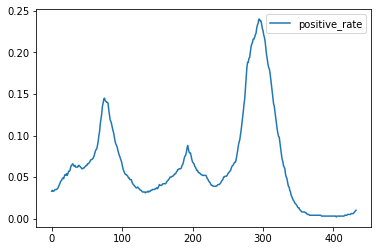

In [169]:
df_master['positive_rate'].plot(legend=True)

In [170]:
#df_master.to_csv('df_master.csv')

In [171]:
### 標準化するものを定義
#normalize_key = ['tested_MA(7days)', 'comparisonPreDay', 'comparisonPreDeclare', 'comparisonPreSpread']
import copy
df_master_normalized = copy.deepcopy(df_master)

normalize_key = df_master_normalized.columns
for key in normalize_key:
  if key != 'date':
    print(key, type(df_master[key][0]))
    for i in range(len(df_master[key])):
      df_master_normalized[key][i] = normalize(df_master[key][i], df_master[key])

hospitalized <class 'numpy.float64'>
light-mid_symptoms <class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


severe_symptoms <class 'numpy.float64'>
dead <class 'numpy.float64'>
discharged <class 'numpy.float64'>
PCR_positive <class 'numpy.float64'>
PCR_negative <class 'numpy.float64'>
tested_MA(7days) <class 'numpy.float64'>
positive_rate <class 'numpy.float64'>
comparisonPreDay <class 'numpy.float64'>
comparisonPreDeclare <class 'numpy.float64'>
comparisonPreSpread <class 'numpy.float64'>


In [172]:
#df_master_normalized.to_csv('df_master_normalized.csv')

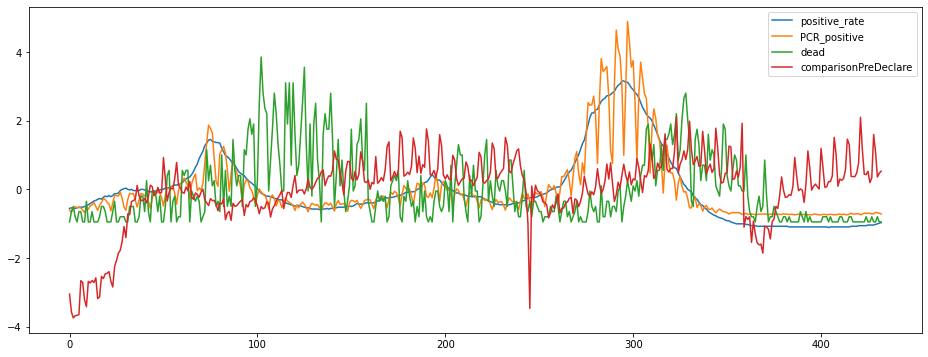

In [173]:
### 確認（図示）
df_master_normalized["positive_rate"].plot(figsize=(16,6),legend = True)
df_master_normalized["PCR_positive"].plot(figsize=(16,6),legend = True)
df_master_normalized["dead"].plot(figsize=(16,6),legend = True)
df_master_normalized["comparisonPreDeclare"].plot(figsize=(16,6),legend = True)
plt.show()

In [174]:
df_master_normalized['date']

0     2020-10-24
1     2020-10-25
2     2020-10-26
3     2020-10-27
4     2020-10-28
         ...    
428   2021-12-26
429   2021-12-27
430   2021-12-28
431   2021-12-29
432   2021-12-30
Name: date, Length: 433, dtype: datetime64[ns]

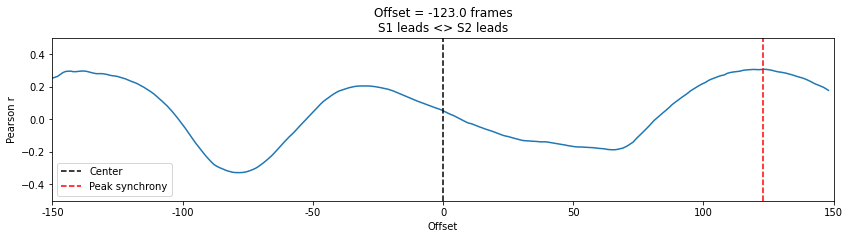

In [175]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

d1 = df_master_normalized['positive_rate']
d2 = df_master_normalized['comparisonPreDeclare']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-.5,.5],xlim=[0,300], xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()])
plt.legend()

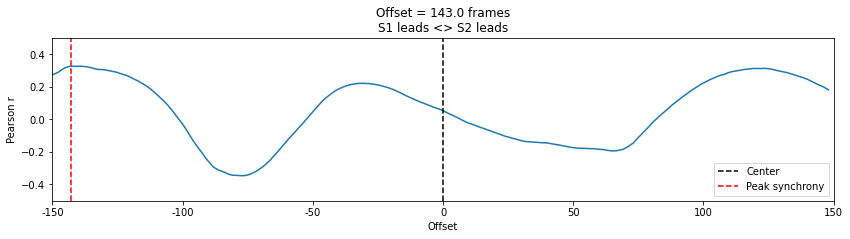

In [176]:
d1 = df_master_normalized['positive_rate']
d2 = df_master_normalized['comparisonPreSpread']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-.5,.5],xlim=[0,300], xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()])
plt.legend()

# New Section